In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import logging, cmdstanpy
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [ ]:
# Load the data
df = pd.read_csv('CONFIDENTIAL', parse_dates=['Day'])

# Define the full date range for holidays (including forecast period)
start_date = df['Day'].min()
end_date = pd.to_datetime('2026-06-30')

In [4]:
# Generate holidays including Pakistan public holidays
holidays = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window'])

# Fixed Gregorian holidays
holidays = pd.concat([
    holidays,
    pd.DataFrame({
        'holiday': 'Kashmir Day',
        'ds': pd.to_datetime(['2023-02-05', '2024-02-05', '2025-02-05', '2026-02-05']),
        'lower_window': -1,
        'upper_window': 1
    }),
    pd.DataFrame({
        'holiday': 'Pakistan Day',
        'ds': pd.to_datetime(['2023-03-23', '2024-03-23', '2025-03-23', '2026-03-23']),
        'lower_window': -1,
        'upper_window': 1
    }),
    pd.DataFrame({
        'holiday': 'Labour Day',
        'ds': pd.to_datetime(['2023-05-01', '2024-05-01', '2025-05-01', '2026-05-01']),
        'lower_window': -1,
        'upper_window': 1
    }),
    pd.DataFrame({
        'holiday': 'Independence Day',
        'ds': pd.to_datetime(['2023-08-14', '2024-08-14', '2025-08-14', '2026-08-14']),
        'lower_window': -1,
        'upper_window': 1
    }),
    pd.DataFrame({
        'holiday': 'Iqbal Day',
        'ds': pd.to_datetime(['2023-11-09', '2024-11-09', '2025-11-09', '2026-11-09']),
        'lower_window': -1,
        'upper_window': 1
    }),
    pd.DataFrame({
        'holiday': 'Quaid-e-Azam Day',
        'ds': pd.to_datetime(['2023-12-25', '2024-12-25', '2025-12-25', '2026-12-25']),
        'lower_window': -1,
        'upper_window': 1
    })
])

# Lunar holidays with approximate 10-11 day shift per year
eid_ul_fitr_dates = pd.to_datetime(['2023-04-21', '2024-04-10', '2025-03-31', '2026-03-20'])  # Adjusted for shift
eid_ul_adha_dates = pd.to_datetime(['2023-06-28', '2024-06-17', '2025-06-06', '2026-05-26'])  # Adjusted for shift
ashura_dates = pd.to_datetime(['2023-07-28', '2024-07-16', '2025-07-05', '2026-06-24'])       # Adjusted for shift

holidays = pd.concat([
    holidays,
    pd.DataFrame({
        'holiday': 'Eid ul Fitr',
        'ds': eid_ul_fitr_dates,
        'lower_window': -2,
        'upper_window': 2
    }),
    pd.DataFrame({
        'holiday': 'Eid ul Adha',
        'ds': eid_ul_adha_dates,
        'lower_window': -2,
        'upper_window': 2
    }),
    pd.DataFrame({
        'holiday': 'Ashura',
        'ds': ashura_dates,
        'lower_window': -1,
        'upper_window': 1
    })
])

# Additional fiscal and specific peaks
month_ends = pd.date_range(start=start_date, end=end_date, freq='M')
quarter_ends = pd.date_range(start=start_date, end=end_date, freq='Q')
year_ends = pd.date_range(start='2023-06-30', end=end_date, freq='A-JUN')
tax_deadlines = pd.date_range(start=start_date, end=end_date, freq='MS').map(lambda x: x + pd.Timedelta(days=14))
specific_peaks = pd.DataFrame({
    'holiday': 'specific_peak',
    'ds': ['2024-11-15', '2025-01-15', '2023-09-15', '2024-08-15'],
    'lower_window': -1,
    'upper_window': 1
})

holidays = pd.concat([
    holidays,
    pd.DataFrame({'holiday': 'holiday', 'ds': month_ends, 'lower_window': -1, 'upper_window': 1}),
    pd.DataFrame({'holiday': 'holiday', 'ds': quarter_ends, 'lower_window': -1, 'upper_window': 1}),
    pd.DataFrame({'holiday': 'holiday', 'ds': year_ends, 'lower_window': -2, 'upper_window': 2}),
    pd.DataFrame({'holiday': 'holiday', 'ds': tax_deadlines, 'lower_window': -1, 'upper_window': 1}),
    specific_peaks
]).drop_duplicates(subset=['ds']).reset_index(drop=True)

In [5]:
# Objective function for Optuna
def objective(trial, column, df, holidays):
    # Suggest parameters
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 1.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 10.0, 25.0),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 5.0, 15.0),
        'monthly_fourier_order': trial.suggest_int('monthly_fourier_order', 5, 25),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'use_log_transform': trial.suggest_categorical('use_log_transform', [True, False])
    }

    # Prepare data
    data = df[['Day', column]].rename(columns={'Day': 'ds', column: 'y'})
    data['y'] = data['y'].replace(0, 1e-3 if column == 'Federal Excise' else 1e-4)
    if params['use_log_transform']:
        data['y'] = np.log1p(data['y'])

    # Split data: train (up to 2024-06-30), validation (2024-07-01 to 2025-06-30)
    train = data[data['ds'] <= '2024-06-30']
    val = data[(data['ds'] > '2024-06-30') & (data['ds'] <= '2025-06-30')]

    # Create and fit Prophet model
    model = Prophet(
        holidays=holidays,
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        yearly_seasonality=True
    )

    logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

    model.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_fourier_order'])
    model.fit(train)

    # Predict on validation period
    future_val = model.make_future_dataframe(periods=365, include_history=True)
    forecast_val = model.predict(future_val)

    # Clip negative predictions and reverse log transformation
    if params['use_log_transform']:
        forecast_val['yhat'] = np.expm1(forecast_val['yhat']).clip(lower=0)
        forecast_val['yhat_lower'] = np.expm1(forecast_val['yhat_lower']).clip(lower=0)
        forecast_val['yhat_upper'] = np.expm1(forecast_val['yhat_upper']).clip(lower=0)
    else:
        forecast_val['yhat'] = forecast_val['yhat'].clip(lower=0)
        forecast_val['yhat_lower'] = forecast_val['yhat_lower'].clip(lower=0)
        forecast_val['yhat_upper'] = forecast_val['yhat_upper'].clip(lower=0)

    # Calculate MAPE
    val_pred = forecast_val[forecast_val['ds'].isin(val['ds'])]['yhat']
    if len(val_pred) == len(val['y']) and len(val_pred) > 0:
        val_actual = np.expm1(val['y']) if params['use_log_transform'] else val['y']
        valid_mask = val_actual >= (5 if column == 'Federal Excise' else 1)
        if valid_mask.sum() > 0:
            mape = np.mean(np.abs((val_actual[valid_mask] - val_pred[valid_mask]) / val_actual[valid_mask])) * 100
        else:
            mape = float('inf')  # Penalize if no valid points
    else:
        mape = float('inf')

    return mape

In [6]:
# Optimize parameters for each column
columns = ['Income Tax', 'Sales Tax', 'Federal Excise', 'Customs Duty', 'Gross Collection']
best_params = {}

for column in columns:
    print(f"\nOptimizing parameters for {column}...")
    # Add seed using TPESampler
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, column, df, holidays), n_trials=100)  # Adjust n_trials as needed
    best_params[column] = study.best_params
    #print(f"Best parameters for {column}: {best_params[column]}")
    print(f"Best MAPE for {column}: {study.best_value:.2f}%")

# Function to forecast with optimized parameters
def forecast_column(column, df, holidays, params, show_uncertainty=False):
    data = df[['Day', column]].rename(columns={'Day': 'ds', column: 'y'})
    data['y'] = data['y'].replace(0, 1e-3 if column == 'Federal Excise' else 1e-4)
    if params.get('use_log_transform', False):
        data['y'] = np.log1p(data['y'])

    train = data[data['ds'] <= '2025-06-30']
    test = data[(data['ds'] > '2025-06-30') & (data['ds'] <= '2026-06-30')]

    near_zero_count = (test['y'] < 1).sum()
    min_test_value = test['y'].min()
    if near_zero_count > 0:
        print(f"Warning: {near_zero_count} near-zero values (y < 1) detected in test set for {column}.")
    print(f"Minimum test set value for {column}: {min_test_value}")
    print(f"Historical value range for {column}: min={data['y'].min()}, max={data['y'].max()}")

    model = Prophet(
        holidays=holidays,
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        yearly_seasonality=True
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_fourier_order'])
    model.fit(train)

    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    if params.get('use_log_transform', False):
        forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
        forecast['yhat_lower'] = np.expm1(forecast['yhat_lower']).clip(lower=0)
        forecast['yhat_upper'] = np.expm1(forecast['yhat_upper']).clip(lower=0)
        forecast['trend'] = np.expm1(forecast['trend']).clip(lower=0)
    else:
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
        forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
        forecast['trend'] = forecast['trend'].clip(lower=0)

    print(f"Forecasted value range for {column}: min={forecast['yhat'].min()}, max={forecast['yhat'].max()}")

    plt.figure(figsize=(36, 20))
    plot_y = np.expm1(data['y']) if params.get('use_log_transform', False) else data['y']
    plt.plot(data['ds'], plot_y, label='Historical', color='blue', alpha=0.5)
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')
    plt.plot(forecast['ds'], forecast['trend'], label='Trend', color='green', linestyle='-')
    if show_uncertainty:
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Uncertainty Interval')
    plt.axvline(pd.to_datetime('2025-06-30'), color='black', linestyle=':', label='Forecast Start')
    plt.title(f'{column} Forecast vs Historical Data with Trend')
    plt.xlabel('Date')
    plt.ylabel('Collection Amount')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{column.replace(" ", "_")}_forecast_plot.png', dpi=900)
    plt.show()
    plt.close()

    # Generate and save component-wise plots
    plt.figure(figsize=(36, 20))
    model.plot_components(forecast)
    plt.savefig(f'{column.replace(" ", "_")}_components_plot.png', dpi=900)
    plt.show()
    plt.close()

    future_forecast = forecast[forecast['ds'] > '2025-06-30'][['ds', 'yhat']]
    return future_forecast

[I 2025-08-20 05:29:08,598] A new study created in memory with name: no-name-2a7fbd44-06e8-407e-865e-562810b18731
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3jhl6jg4/ys6p8gch.json



Optimizing parameters for Income Tax...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3jhl6jg4/mu0ry2ci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63097', 'data', 'file=/tmp/tmp3jhl6jg4/ys6p8gch.json', 'init=/tmp/tmp3jhl6jg4/mu0ry2ci.json', 'output', 'file=/tmp/tmp3jhl6jg4/prophet_modelwdf19bfp/prophet_model-20250820052909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-08-20 05:29:09,909] Trial 0 finished with value: 2486.7199989110995 and parameters: {'changepoint_prior_scale': 0.5680647770825701, 'seasonality_prior_scale': 24.260714596148745, 'holidays_prior_scale': 12.31993941811405, 'monthly_fourier_order': 17, 'seasonality_mode': 'additive', 'use_log_trans

Best MAPE for Income Tax: 107.83%

Optimizing parameters for Sales Tax...


[I 2025-08-20 05:31:06,626] Trial 0 finished with value: 333.8565686708816 and parameters: {'changepoint_prior_scale': 0.5680647770825701, 'seasonality_prior_scale': 24.260714596148745, 'holidays_prior_scale': 12.31993941811405, 'monthly_fourier_order': 17, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 333.8565686708816.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:31:07,294] Trial 1 finished with value: 346.42362540636117 and parameters: {'changepoint_prior_scale': 0.9056613674973811, 'seasonality_prior_scale': 20.621088666940683, 'holidays_prior_scale': 5.2058449429580245, 'monthly_fourier_order': 25, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 333.8565686708816.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:31:07,919] Trial 2 finished with value: 330.30470

Best MAPE for Sales Tax: 61.13%

Optimizing parameters for Federal Excise...


[I 2025-08-20 05:32:21,377] Trial 0 finished with value: 1213.0763826262225 and parameters: {'changepoint_prior_scale': 0.5680647770825701, 'seasonality_prior_scale': 24.260714596148745, 'holidays_prior_scale': 12.31993941811405, 'monthly_fourier_order': 17, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 1213.0763826262225.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:32:21,998] Trial 1 finished with value: 1254.0332317406612 and parameters: {'changepoint_prior_scale': 0.9056613674973811, 'seasonality_prior_scale': 20.621088666940683, 'holidays_prior_scale': 5.2058449429580245, 'monthly_fourier_order': 25, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 1213.0763826262225.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:32:22,600] Trial 2 finished with value: 1212.0

Best MAPE for Federal Excise: 131.44%

Optimizing parameters for Customs Duty...


[I 2025-08-20 05:33:36,312] Trial 0 finished with value: 368.66196048954396 and parameters: {'changepoint_prior_scale': 0.5680647770825701, 'seasonality_prior_scale': 24.260714596148745, 'holidays_prior_scale': 12.31993941811405, 'monthly_fourier_order': 17, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 368.66196048954396.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:33:37,746] Trial 1 finished with value: 326.9356052728407 and parameters: {'changepoint_prior_scale': 0.9056613674973811, 'seasonality_prior_scale': 20.621088666940683, 'holidays_prior_scale': 5.2058449429580245, 'monthly_fourier_order': 25, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 1 with value: 326.9356052728407.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:33:38,510] Trial 2 finished with value: 372.5726

Best MAPE for Customs Duty: 60.60%

Optimizing parameters for Gross Collection...


[I 2025-08-20 05:34:56,089] Trial 0 finished with value: 887.3069383536571 and parameters: {'changepoint_prior_scale': 0.5680647770825701, 'seasonality_prior_scale': 24.260714596148745, 'holidays_prior_scale': 12.31993941811405, 'monthly_fourier_order': 17, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 887.3069383536571.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:34:56,893] Trial 1 finished with value: 1046.5294298474087 and parameters: {'changepoint_prior_scale': 0.9056613674973811, 'seasonality_prior_scale': 20.621088666940683, 'holidays_prior_scale': 5.2058449429580245, 'monthly_fourier_order': 25, 'seasonality_mode': 'additive', 'use_log_transform': False}. Best is trial 0 with value: 887.3069383536571.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2025-08-20 05:34:57,602] Trial 2 finished with value: 811.74324

Best MAPE for Gross Collection: 71.39%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minimum test set value for Income Tax: nan
Historical value range for Income Tax: min=0.8644069473921652, max=12.272871696150919
Forecasted value range for Income Tax: min=0.0, max=284889.63577391114


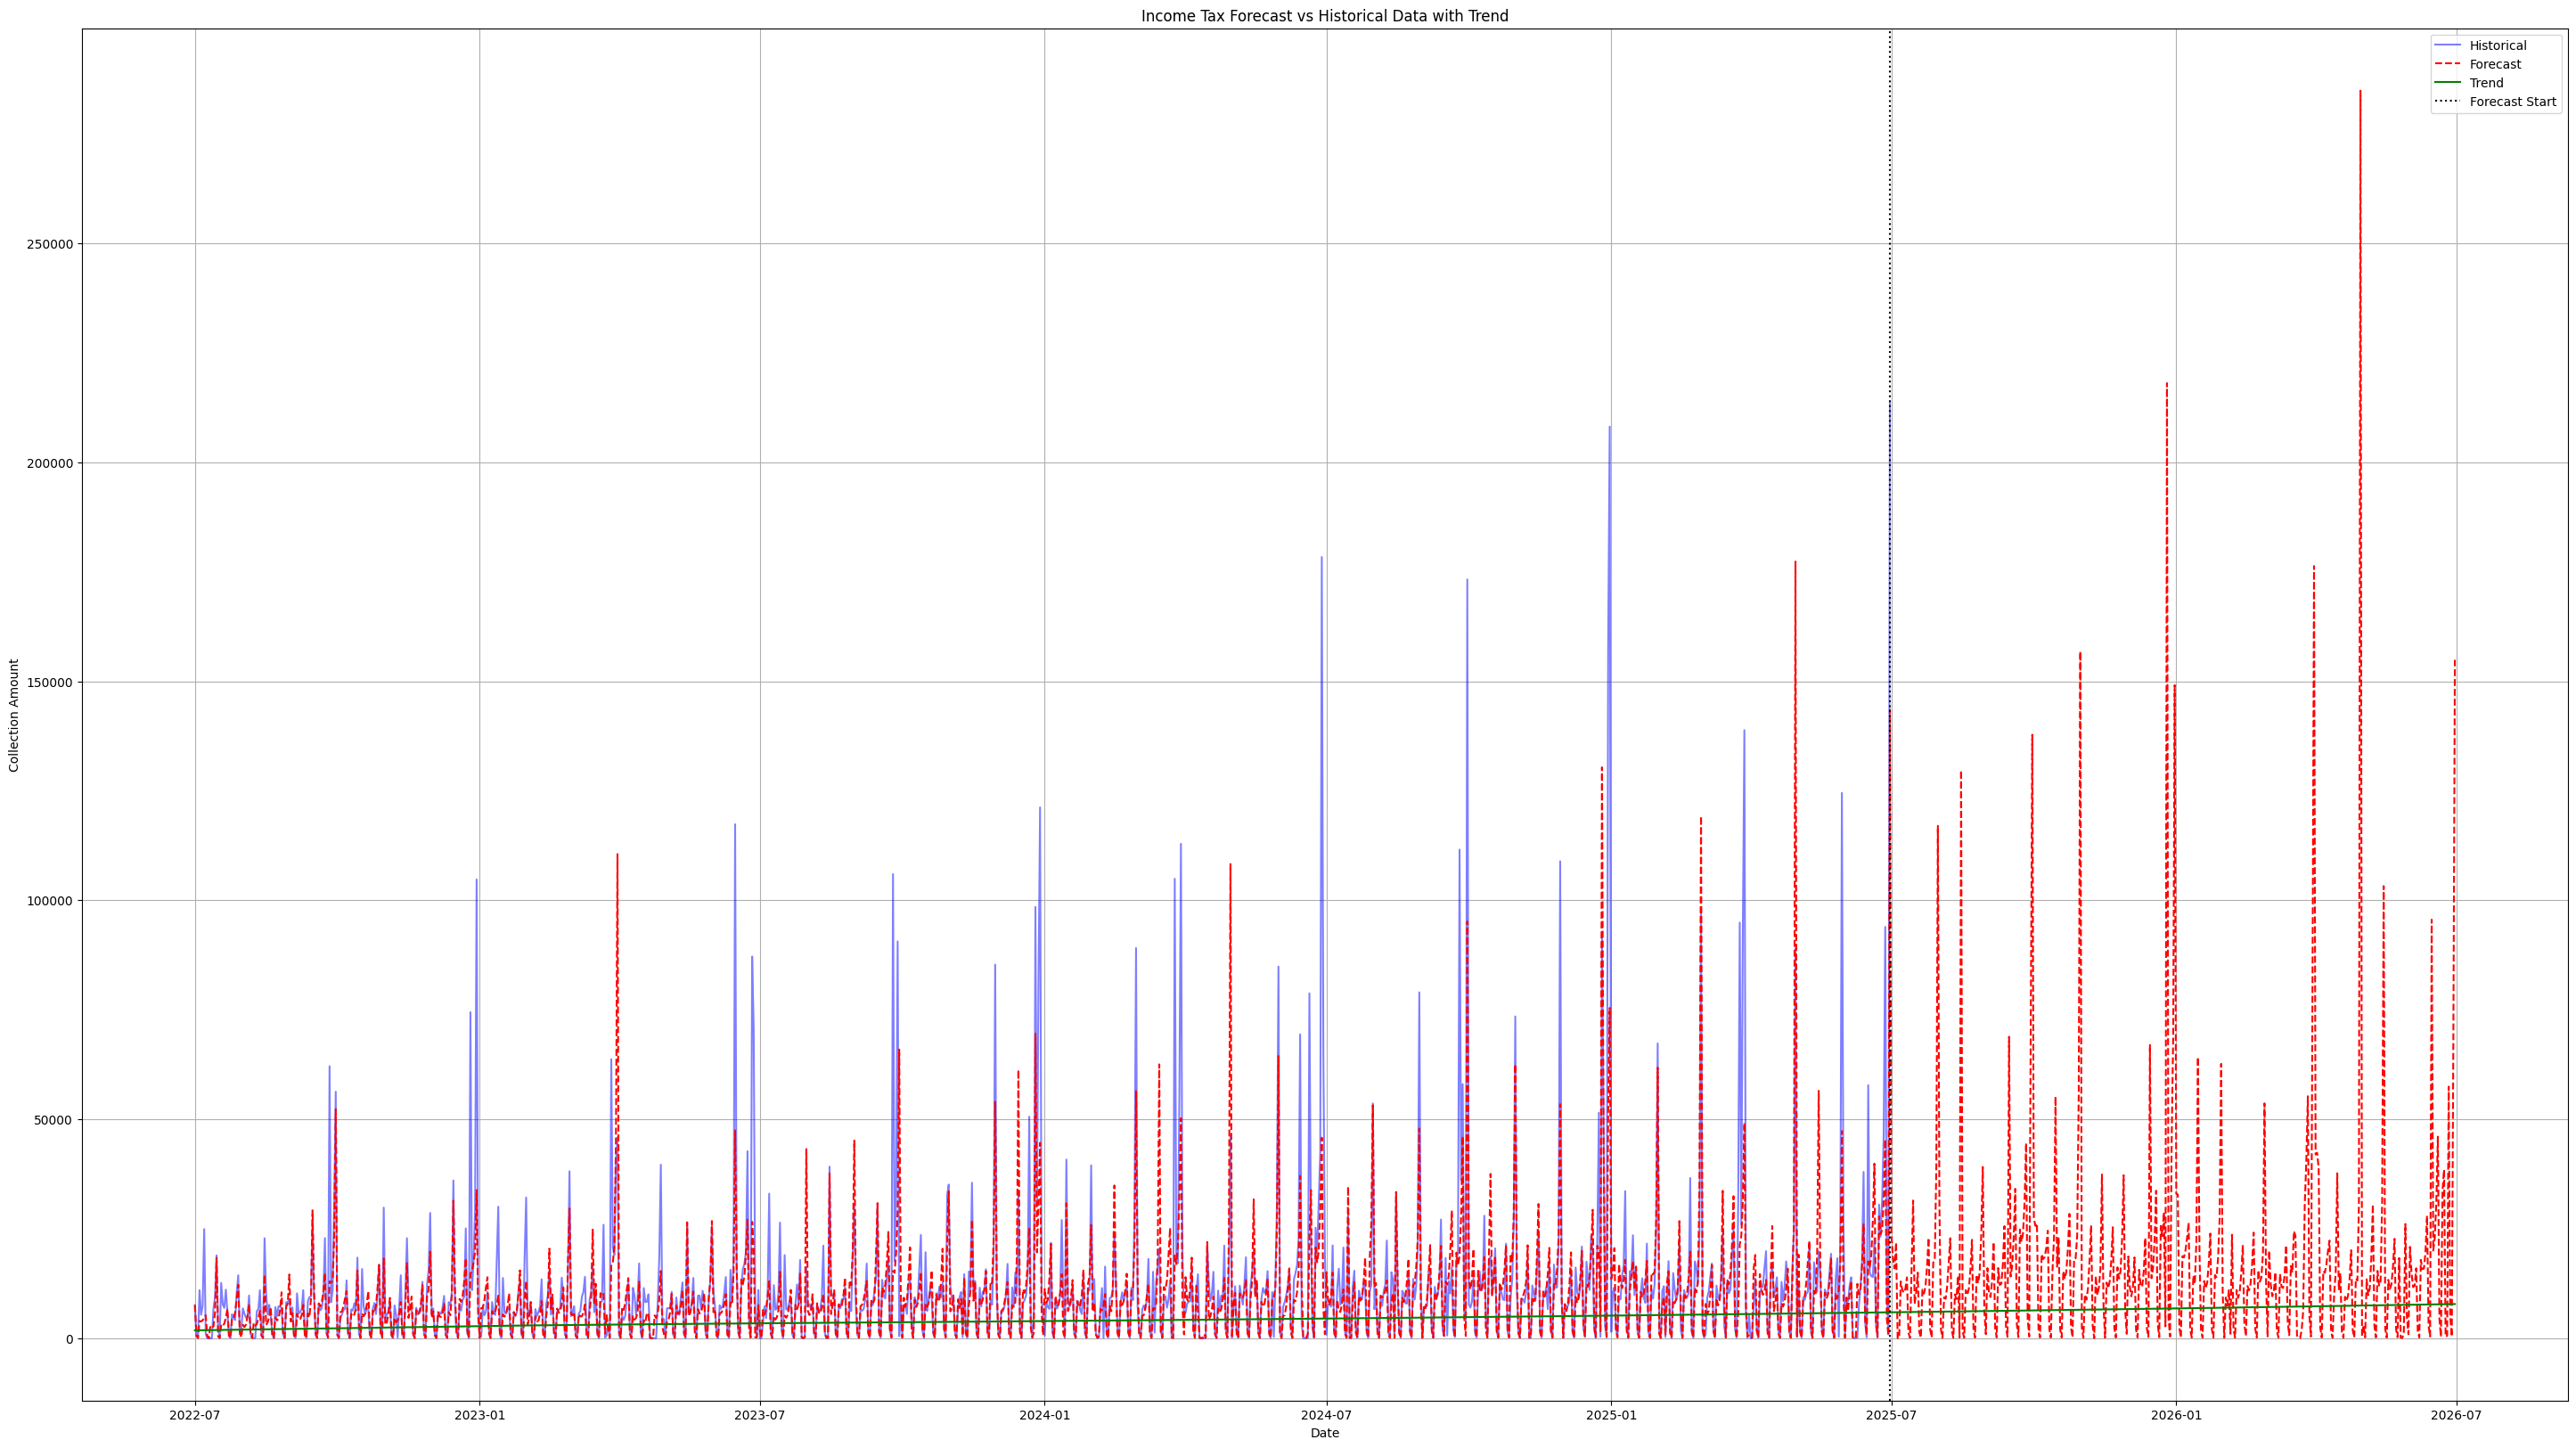

<Figure size 3600x2000 with 0 Axes>

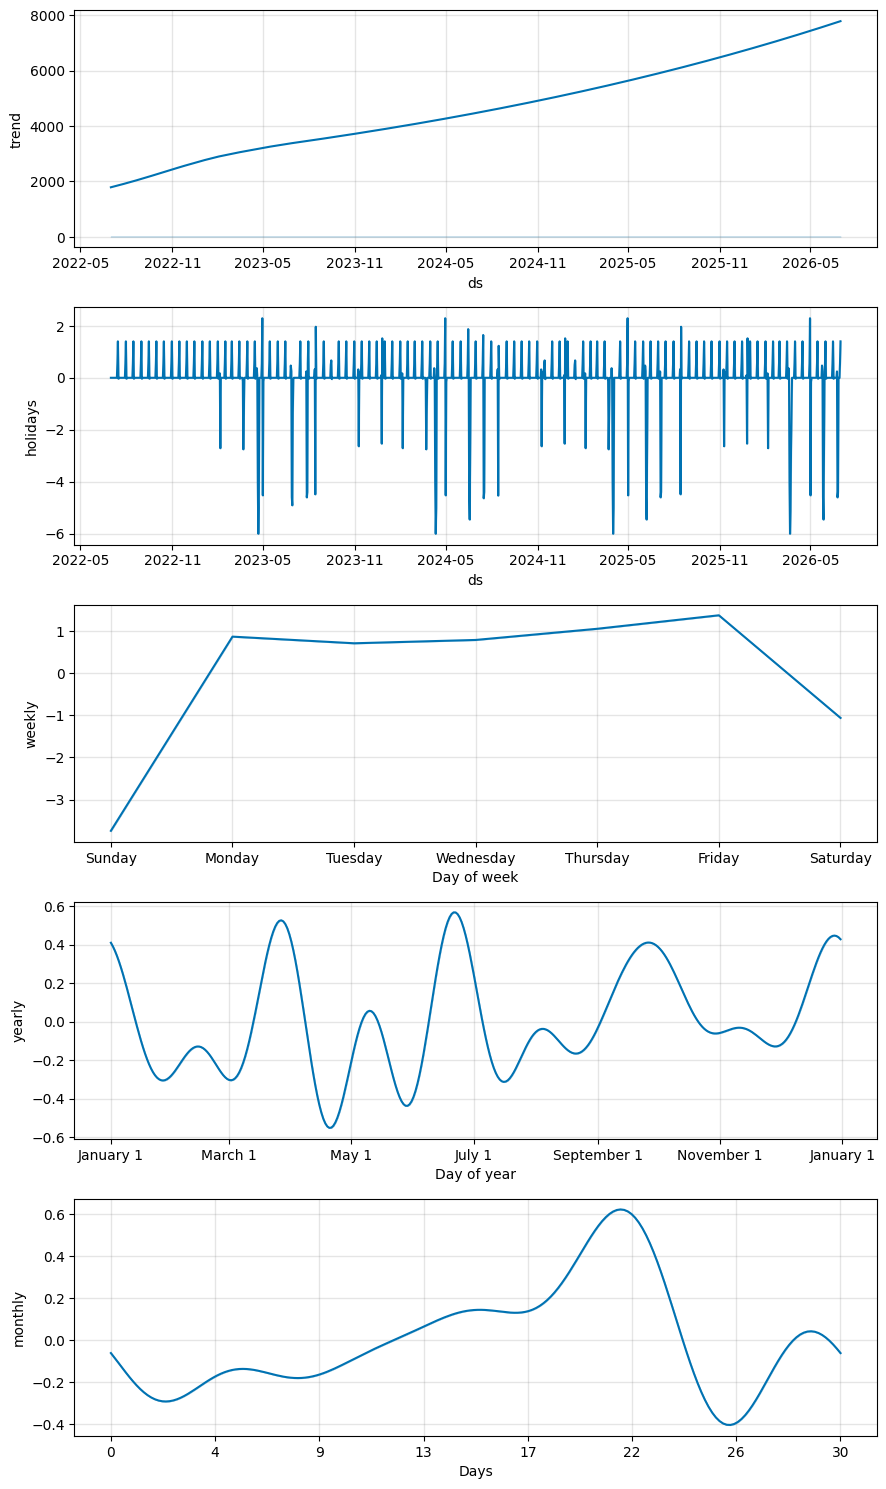

Minimum test set value for Sales Tax: nan
Historical value range for Sales Tax: min=1.41888472856911, max=11.080472757551867


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasted value range for Sales Tax: min=1.1436151399815448, max=92368.33142646671


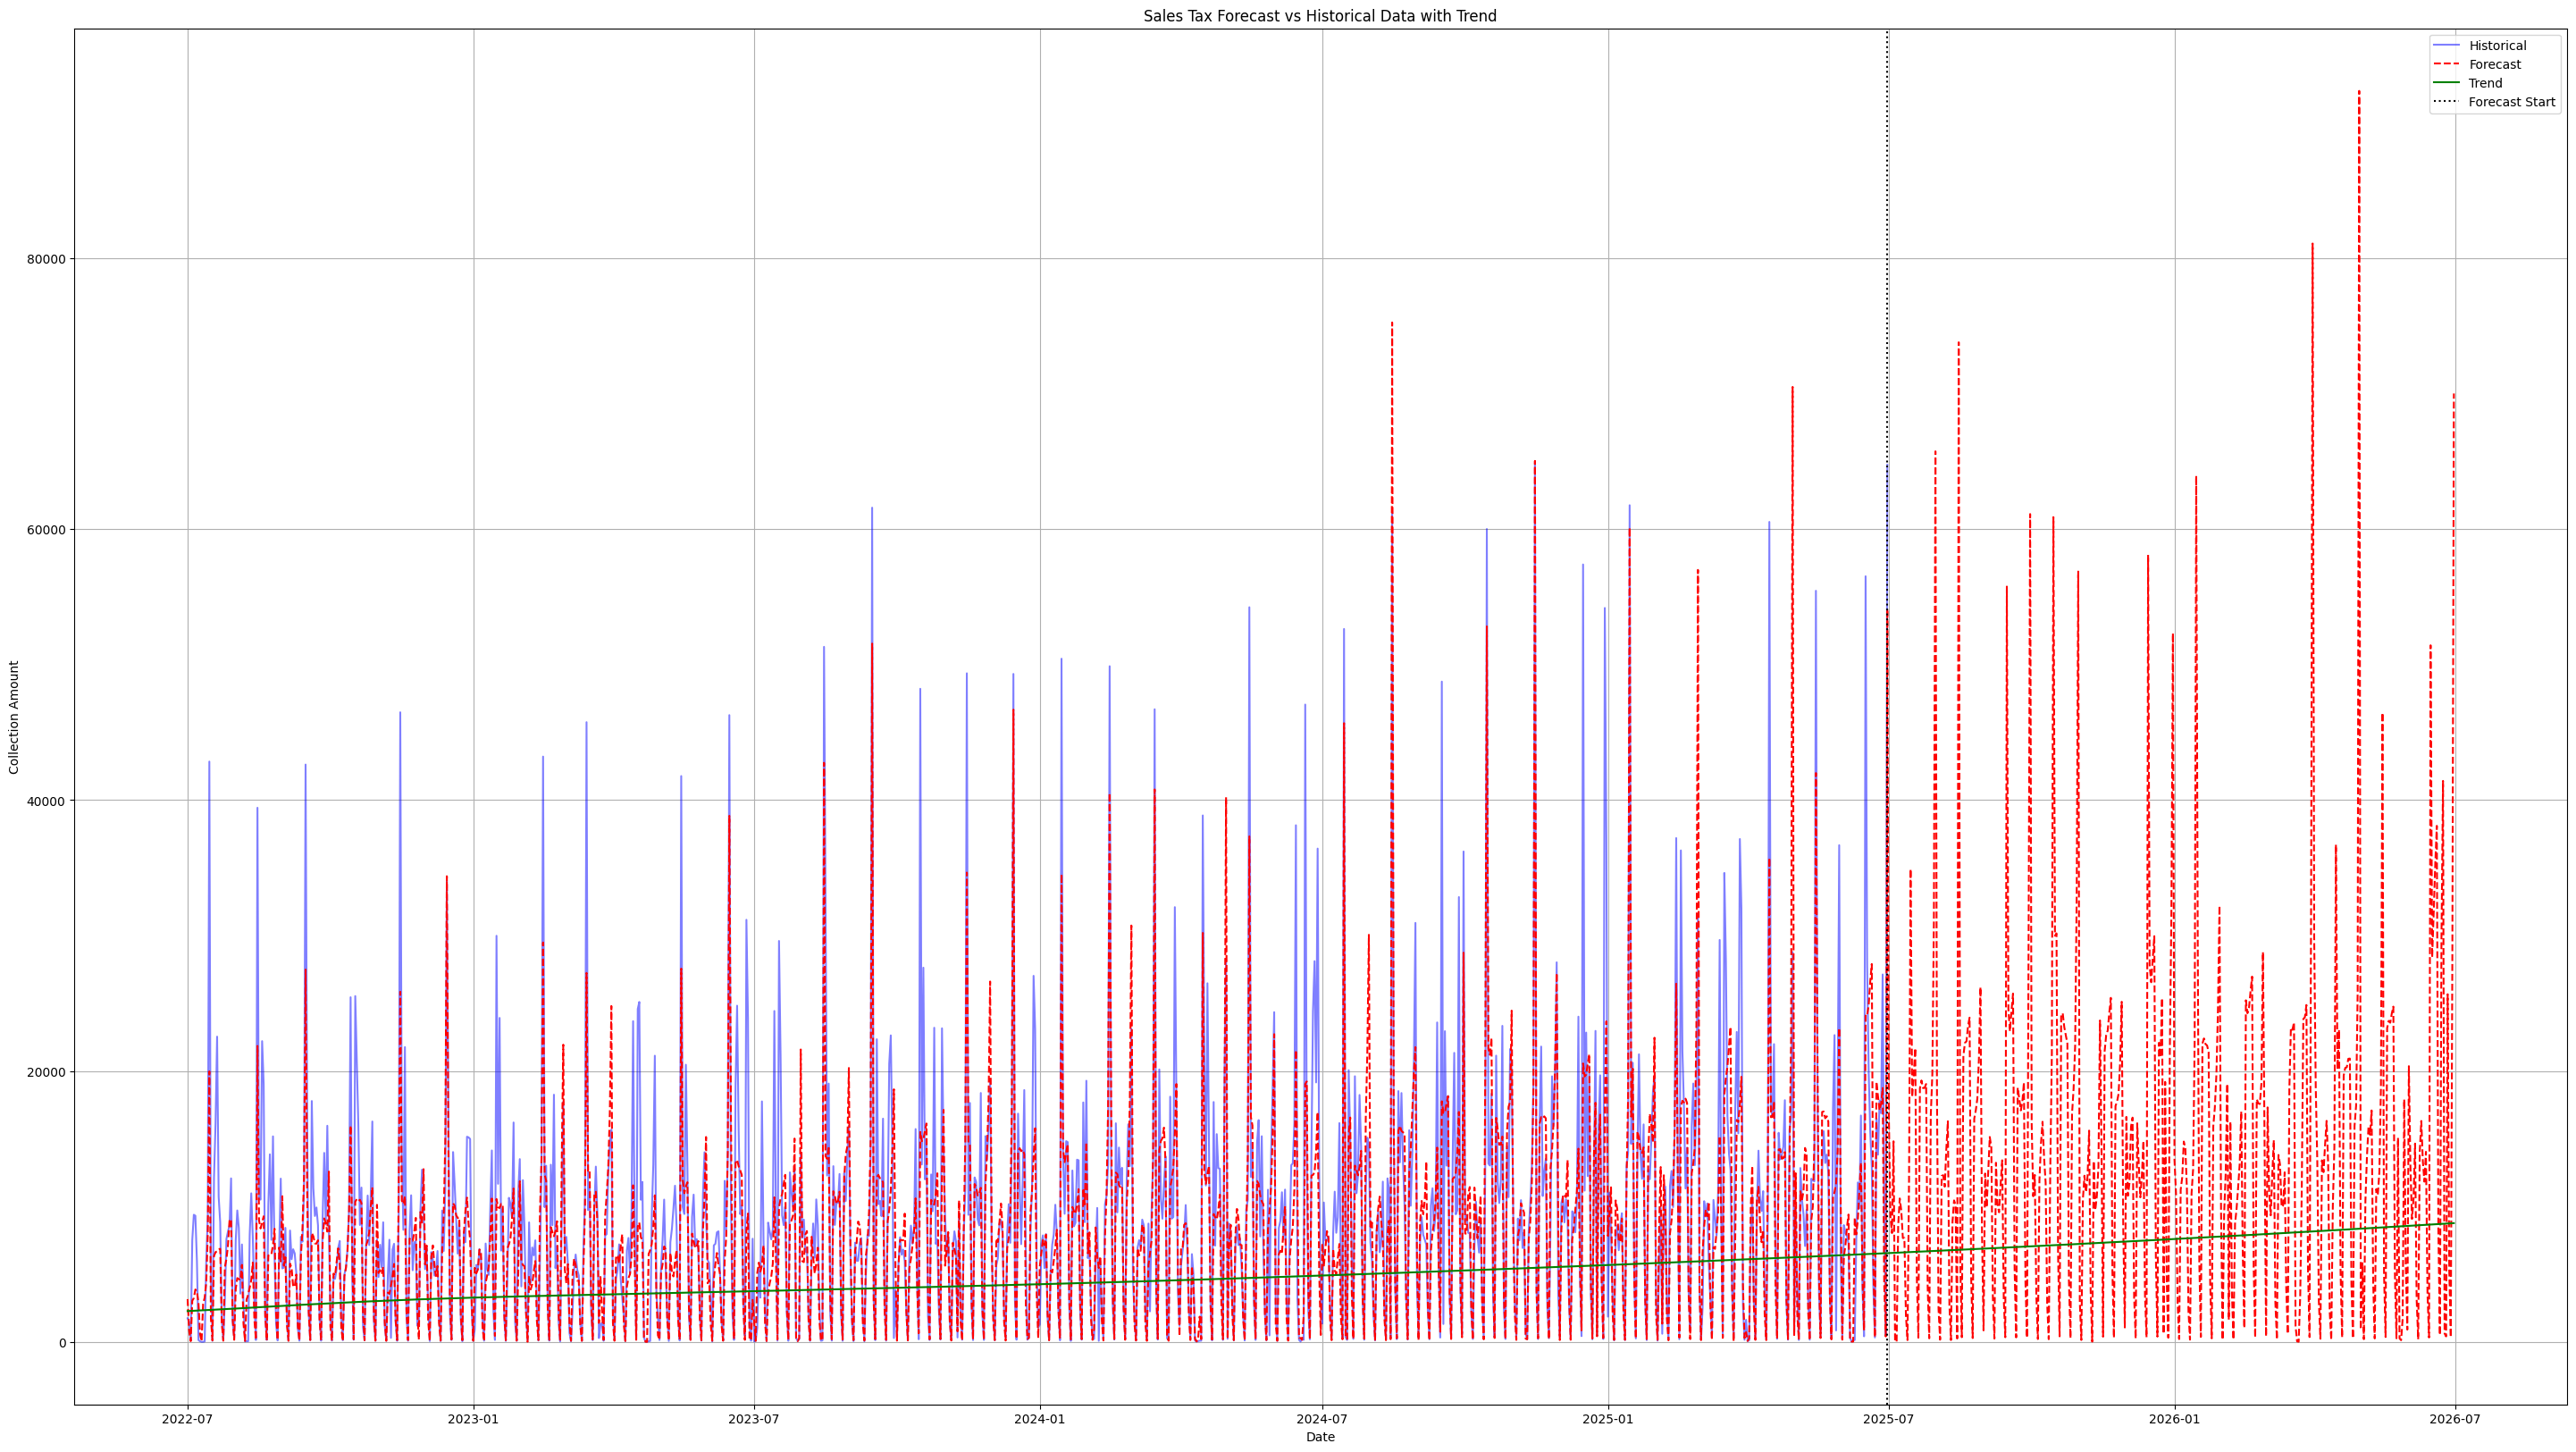

<Figure size 3600x2000 with 0 Axes>

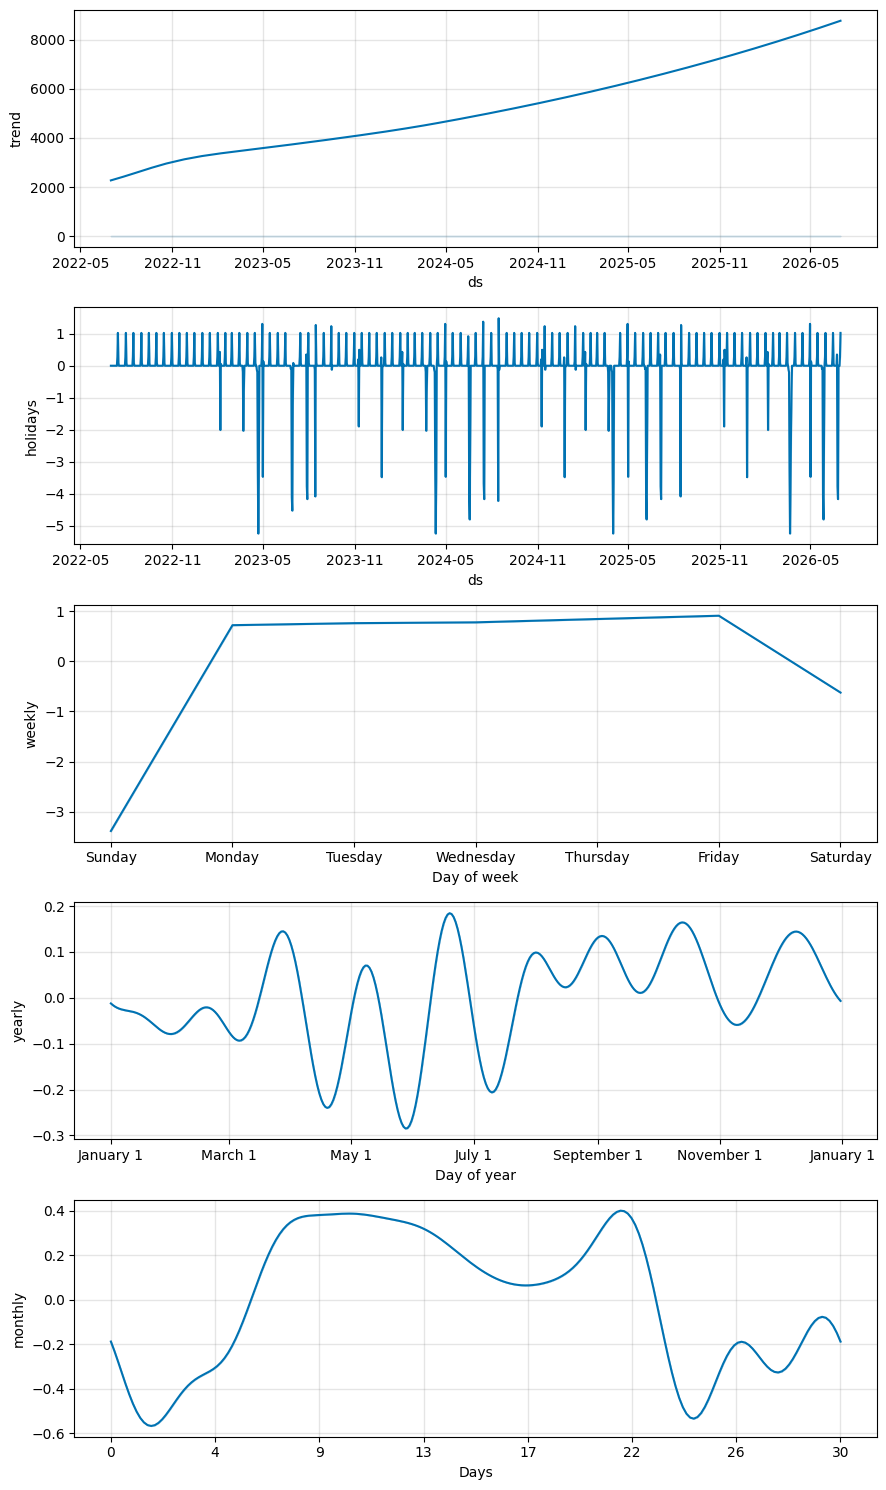

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minimum test set value for Federal Excise: nan
Historical value range for Federal Excise: min=1.9999980000026667e-06, max=10.477230055476317
Forecasted value range for Federal Excise: min=0.0, max=84909.88701199356


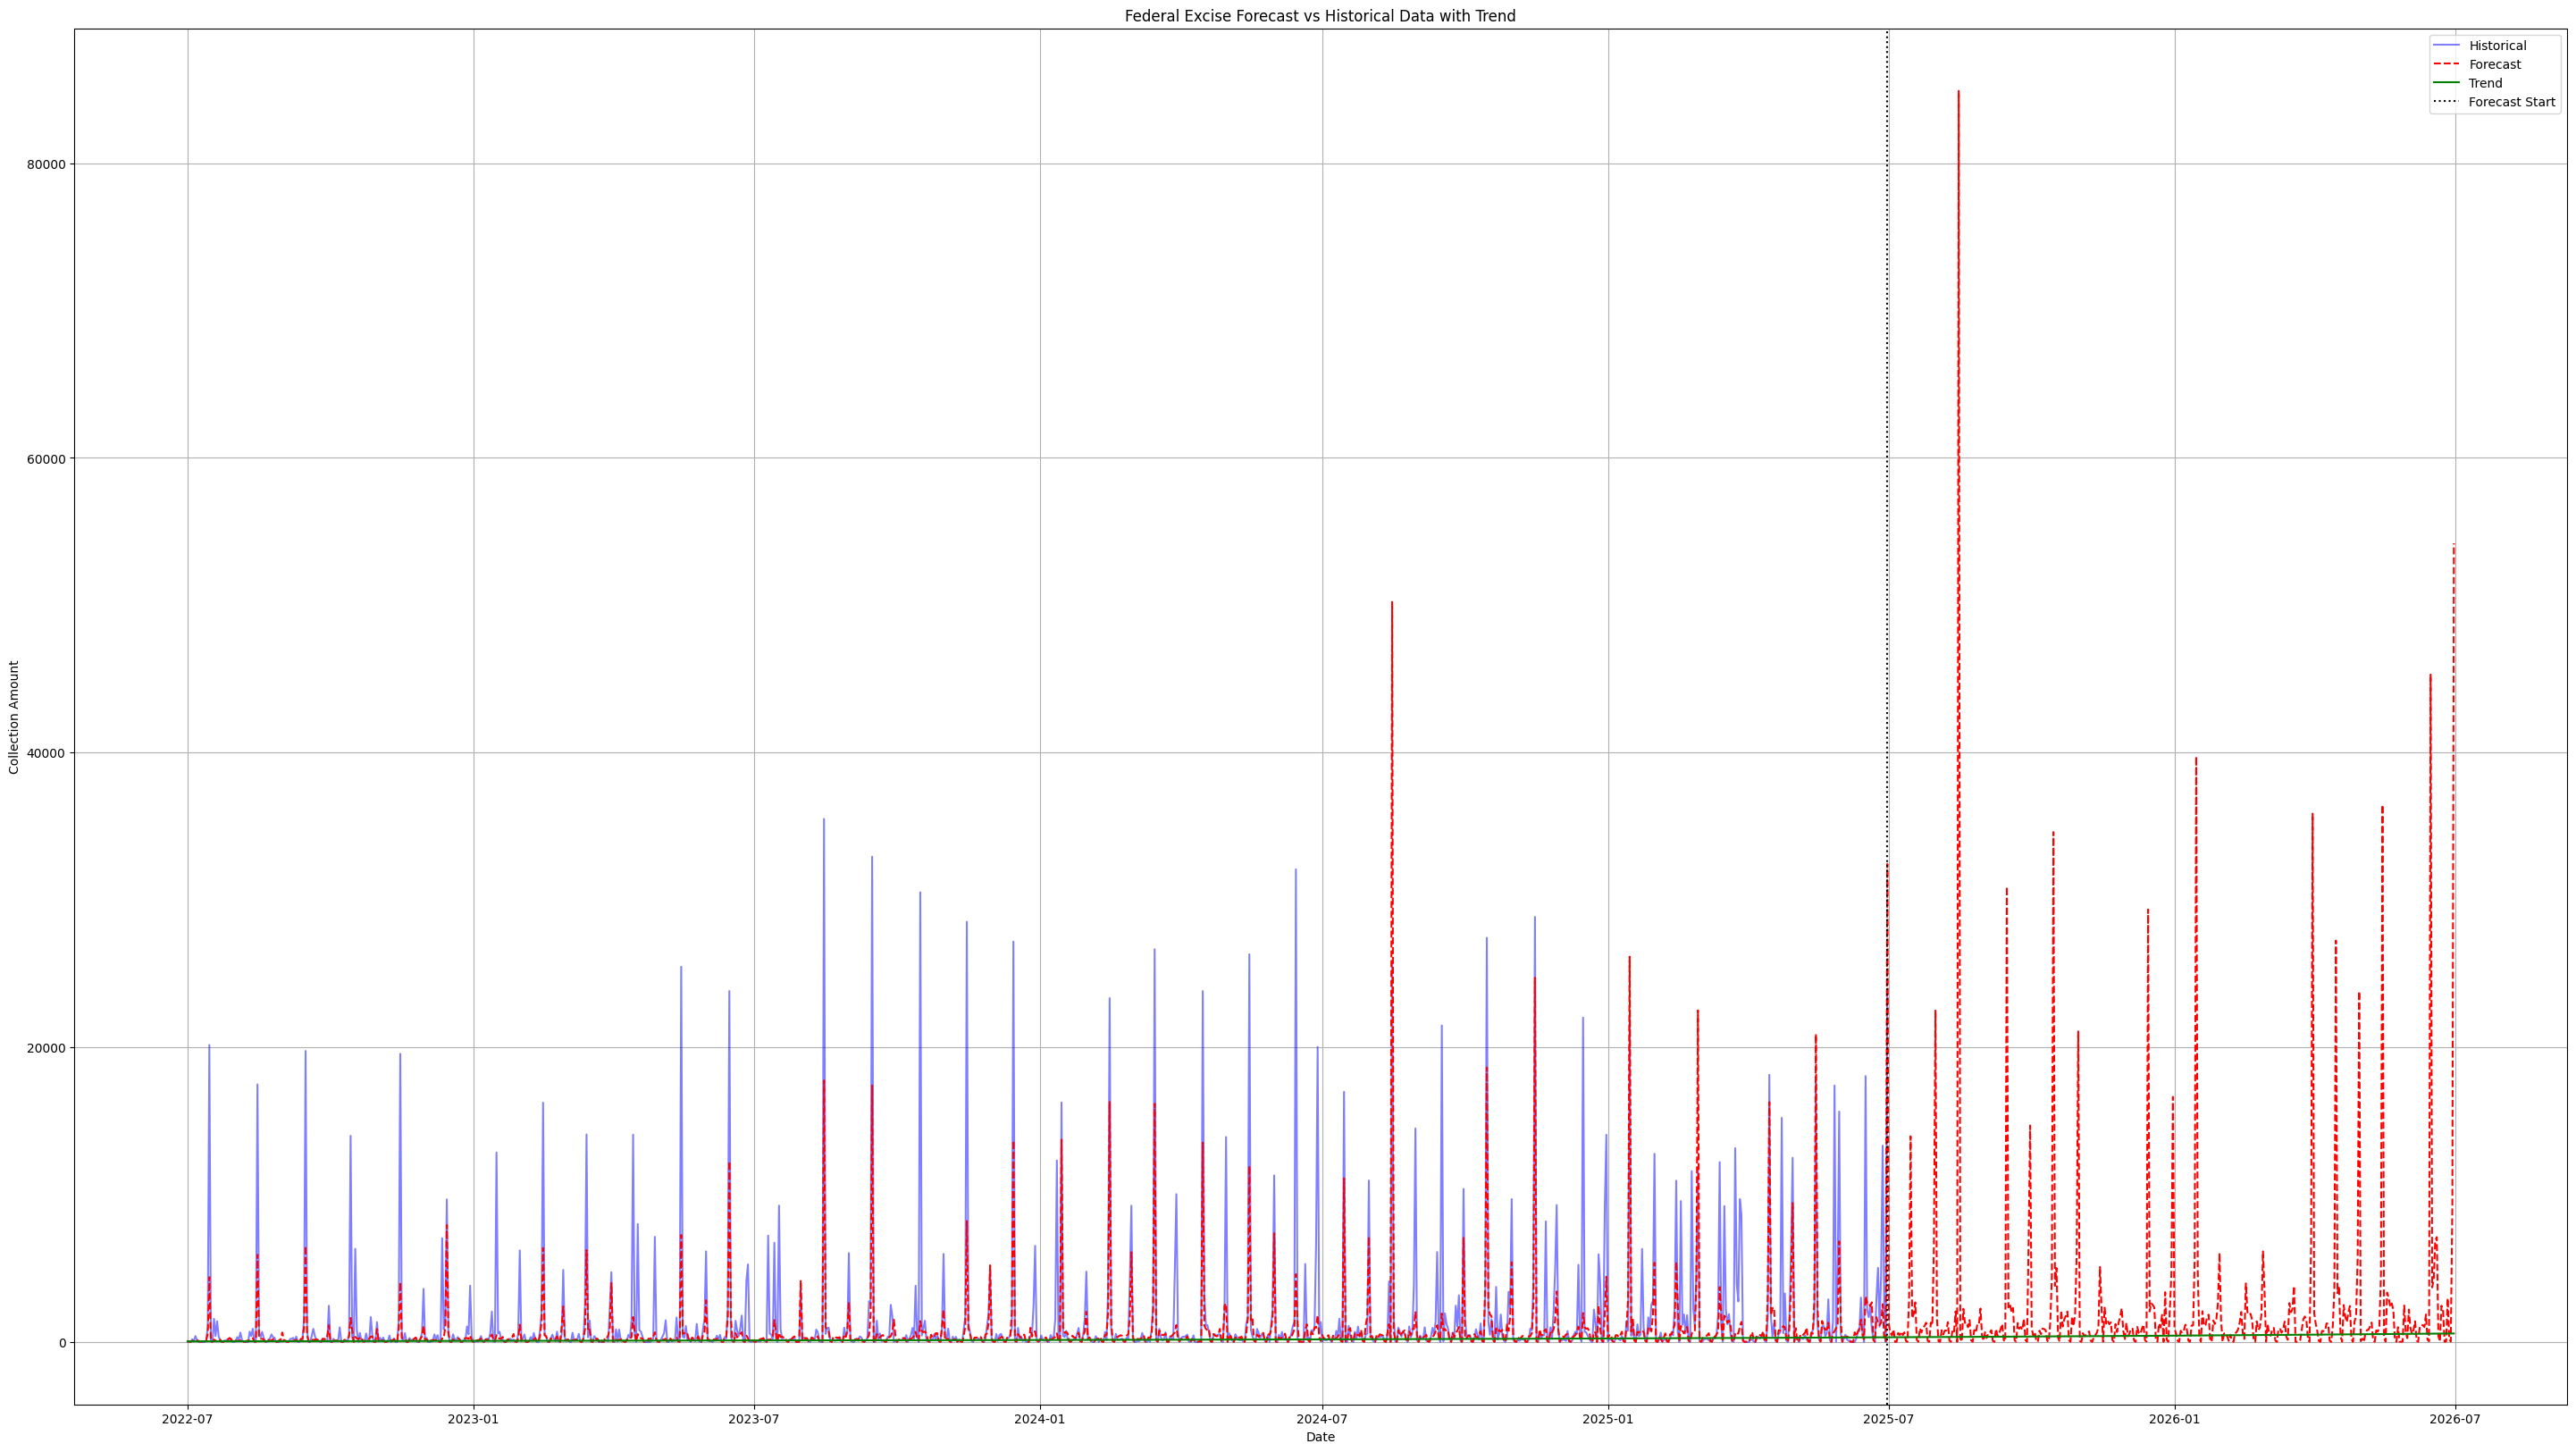

<Figure size 3600x2000 with 0 Axes>

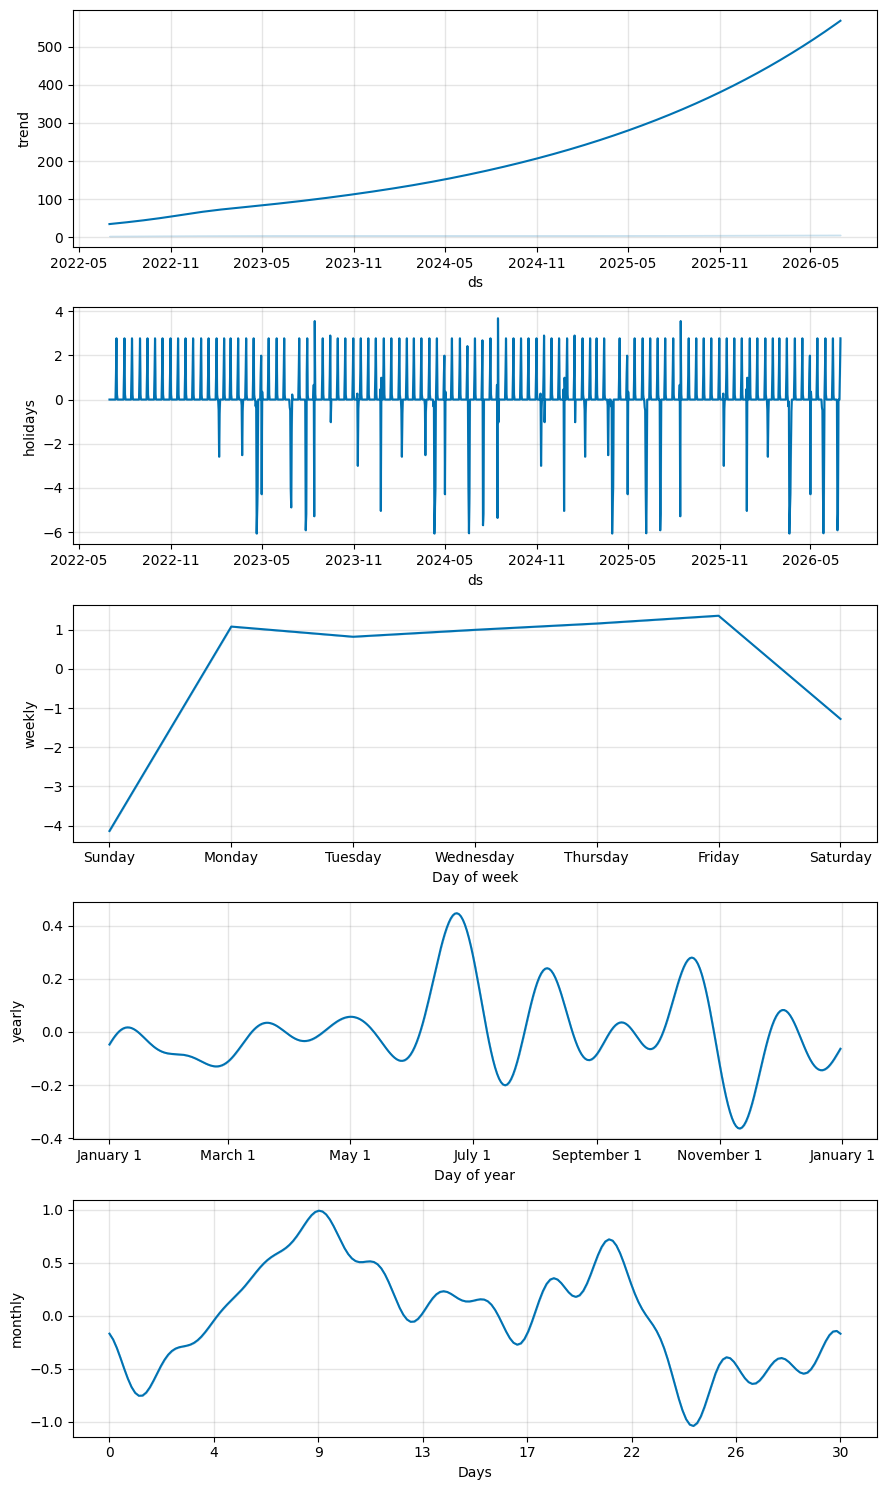

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minimum test set value for Customs Duty: nan
Historical value range for Customs Duty: min=1.185369633394276, max=9.893516301434133
Forecasted value range for Customs Duty: min=0.6218707489168147, max=17348.106183683583


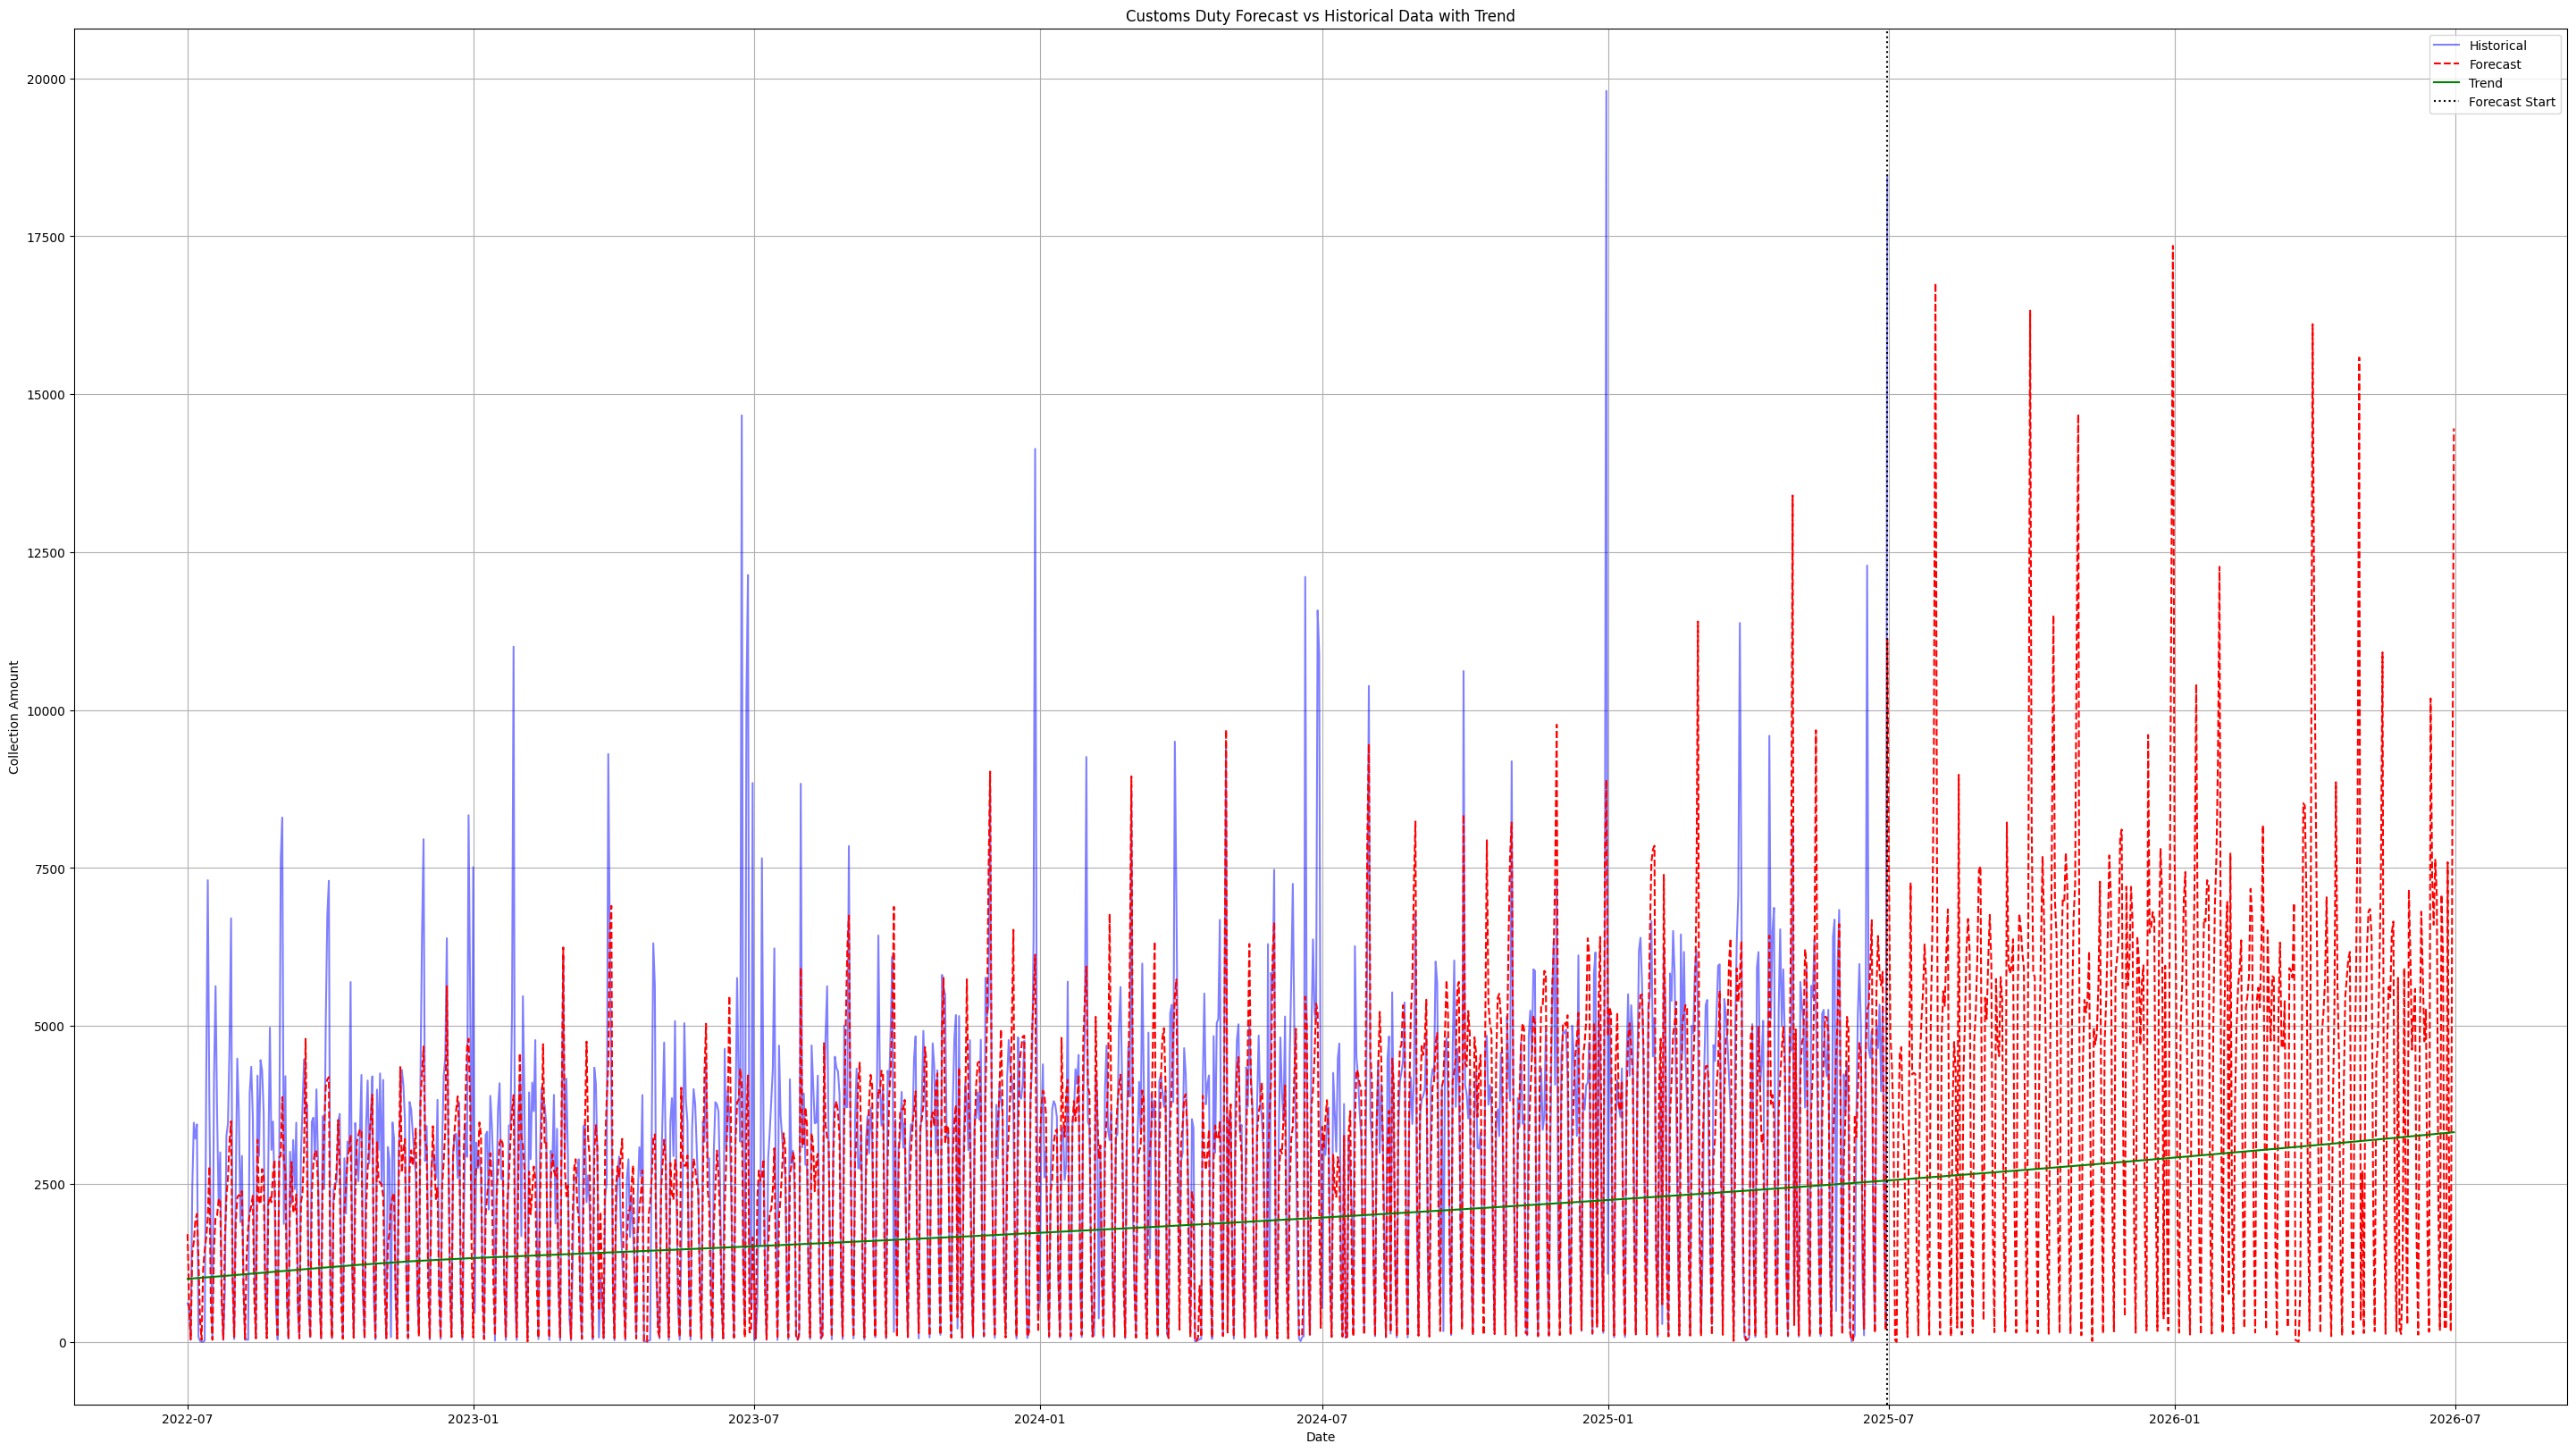

<Figure size 3600x2000 with 0 Axes>

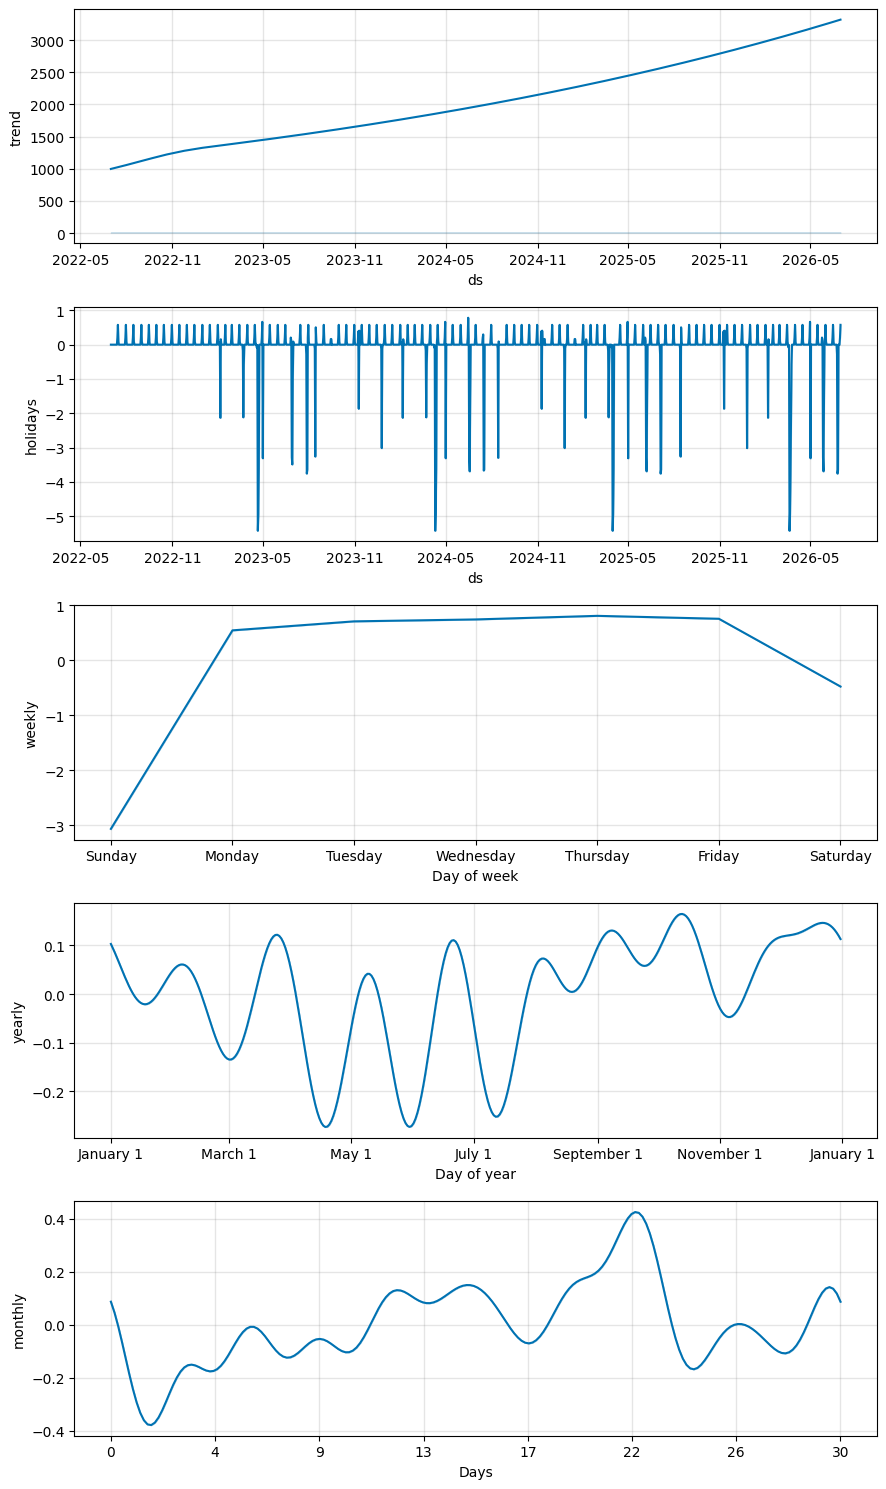

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minimum test set value for Gross Collection: nan
Historical value range for Gross Collection: min=2.051299878572125, max=12.67811605238935
Forecasted value range for Gross Collection: min=2.4917578458903993, max=440911.8847999397


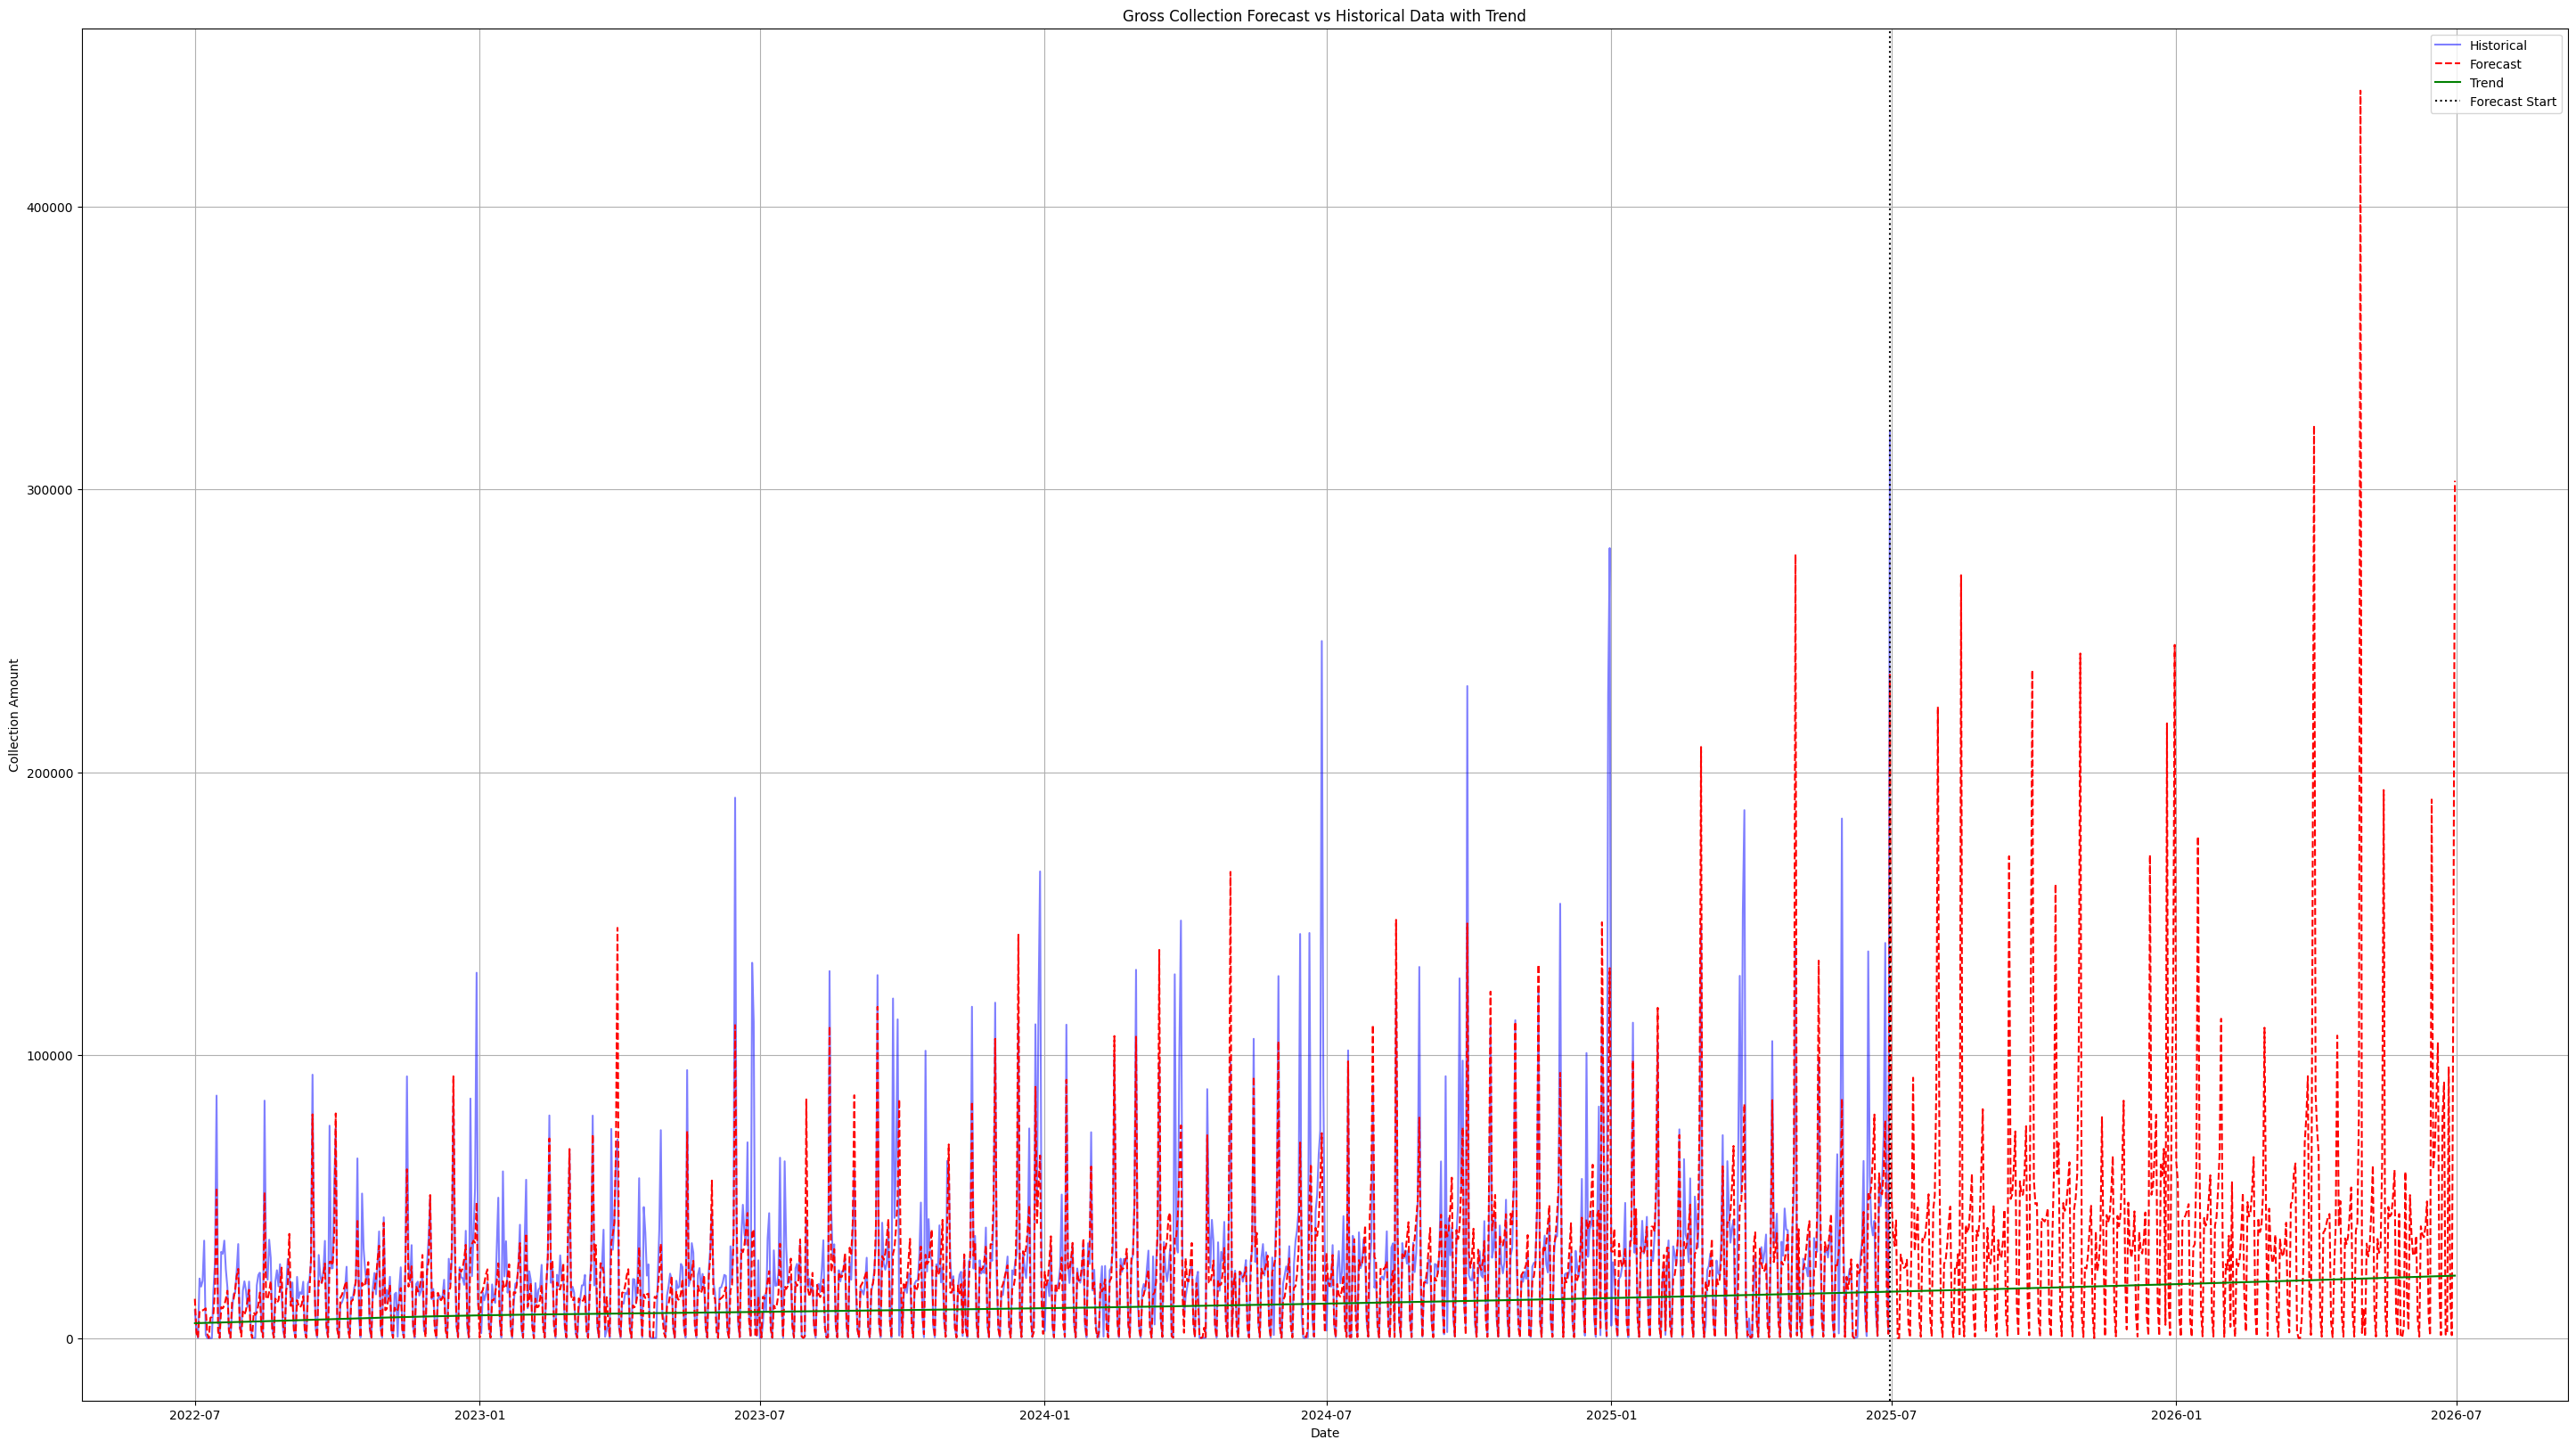

<Figure size 3600x2000 with 0 Axes>

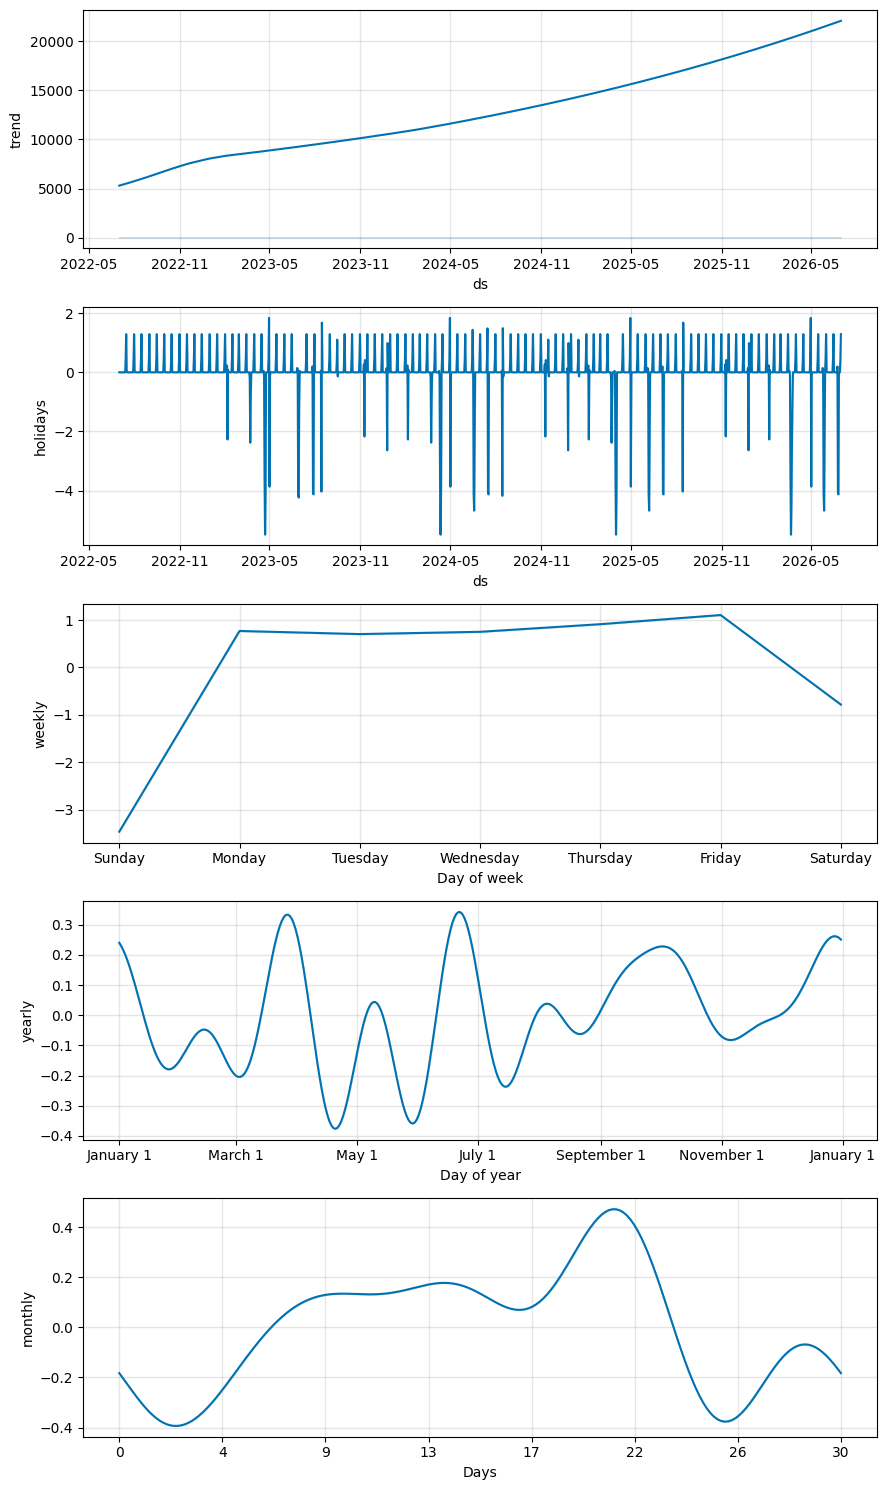

In [7]:
# Create forecast DataFrame
future_dates = pd.date_range(start='2025-07-01', end='2026-06-30')
forecast_df = pd.DataFrame({'ds': future_dates})

# Forecast with optimized parameters
for column in columns:
    future_forecast = forecast_column(column, df, holidays, best_params[column], show_uncertainty=False)
    forecast_df[column + '_forecast'] = future_forecast['yhat'].values

# Compute sum of individual forecasts
forecast_df['Gross Collection_sum'] = forecast_df[[col + '_forecast' for col in columns[:-1]]].sum(axis=1)

# Save forecasts to CSV
forecast_df.to_csv('forecasts.csv', index=False)

In [8]:
import openpyxl
from openpyxl.styles import Border, Side, Alignment

# Load the forecast data
forecast_df = pd.read_csv('forecasts.csv', parse_dates=['ds'])

# Function to process and save monthly forecasts into one Excel file
def create_monthly_excel(forecast_df):
    # Define the date range for forecasting (July 2025 to June 2026)
    start_date = pd.to_datetime('2025-07-01')
    end_date = pd.to_datetime('2026-06-30')

    # List of forecast columns
    columns = ['Income Tax_forecast', 'Sales Tax_forecast', 'Federal Excise_forecast',
               'Customs Duty_forecast', 'Gross Collection_forecast', 'Gross Collection_sum']

    # Create a single Excel writer
    with pd.ExcelWriter('all_forecasts.xlsx', engine='openpyxl') as writer:
        # Iterate over each month
        current_date = start_date
        while current_date <= end_date:
            month_end = current_date + pd.offsets.MonthEnd(0)
            month_data = forecast_df[(forecast_df['ds'] >= current_date) & (forecast_df['ds'] <= month_end)].copy()

            if not month_data.empty:
                # Create a DataFrame for the month
                monthly_df = pd.DataFrame({'Date': month_data['ds'].dt.date})
                for column in columns:
                    monthly_df[column] = month_data[column]

                # Initialize final DataFrame
                final_df = pd.DataFrame()

                # Dynamically determine weeks based on the month's days
                current_week_start = current_date
                week_num = 1
                while current_week_start <= month_end:
                    week_end = min(current_week_start + pd.Timedelta(days=6), month_end)
                    week_data = monthly_df[(pd.to_datetime(monthly_df['Date']) >= current_week_start) &
                                        (pd.to_datetime(monthly_df['Date']) <= week_end)]
                    if not week_data.empty:
                        # Add daily data
                        final_df = pd.concat([final_df, week_data], ignore_index=True)
                        # Add weekly totals
                        weekly_totals = week_data[columns].sum()
                        weekly_totals_df = pd.DataFrame({
                            'Date': [f'Week {week_num} Total'],
                            **{col: [weekly_totals[col]] for col in columns}
                        })
                        final_df = pd.concat([final_df, weekly_totals_df], ignore_index=True)
                        # Add weekly averages
                        weekly_averages = week_data[columns].mean()
                        weekly_averages_df = pd.DataFrame({
                            'Date': [f'Week {week_num} Average'],
                            **{col: [weekly_averages[col]] for col in columns}
                        })
                        final_df = pd.concat([final_df, weekly_averages_df], ignore_index=True)
                    current_week_start = week_end + pd.Timedelta(days=1)
                    week_num += 1

                # Add monthly totals and averages at the end
                monthly_total = monthly_df[columns].sum()
                monthly_average = monthly_df[columns].mean()
                monthly_summary = pd.DataFrame({
                    'Date': ['Monthly Total', 'Monthly Average'],
                    **{col: [monthly_total[col], monthly_average[col]] for col in columns}
                })
                final_df = pd.concat([final_df, monthly_summary], ignore_index=True)

                # Save to Excel as a new sheet with month name
                sheet_name = current_date.strftime('%B_%Y')
                final_df.to_excel(writer, sheet_name=sheet_name, index=False, header=True, startrow=2)

                # Access the worksheet
                workbook = writer.book
                worksheet = writer.sheets[sheet_name]

                # Add title
                worksheet['A1'] = f'Forecast Summary for {current_date.strftime("%B %Y")}'
                worksheet.merge_cells('A1:F1')
                title_cell = worksheet['A1']
                title_cell.alignment = Alignment(horizontal='center', vertical='center')
                title_cell.font = openpyxl.styles.Font(bold=True, size=14)

                # Apply borders and formatting
                thin_border = Border(left=Side(style='thin'),
                                   right=Side(style='thin'),
                                   top=Side(style='thin'),
                                   bottom=Side(style='thin'))

                # Apply borders to all cells with data
                for row in worksheet.rows:
                    for cell in row:
                        cell.border = thin_border
                        cell.alignment = Alignment(horizontal='center', vertical='center')

                # Adjust column widths (all columns set to 25)
                for i in range(1, len(columns) + 2):  # +2 for Date column and 1-based indexing
                    worksheet.column_dimensions[openpyxl.utils.get_column_letter(i)].width = 25

                # Freeze the header row
                worksheet.freeze_panes = 'A3'  # Adjusted to freeze after title and header

                print(f"Saved sheet '{sheet_name}' in all_forecasts.xlsx")

            current_date = month_end + pd.Timedelta(days=1)

# Run the function with the forecast data
create_monthly_excel(forecast_df)

Saved sheet 'July_2025' in all_forecasts.xlsx
Saved sheet 'August_2025' in all_forecasts.xlsx
Saved sheet 'September_2025' in all_forecasts.xlsx
Saved sheet 'October_2025' in all_forecasts.xlsx
Saved sheet 'November_2025' in all_forecasts.xlsx
Saved sheet 'December_2025' in all_forecasts.xlsx
Saved sheet 'January_2026' in all_forecasts.xlsx
Saved sheet 'February_2026' in all_forecasts.xlsx
Saved sheet 'March_2026' in all_forecasts.xlsx
Saved sheet 'April_2026' in all_forecasts.xlsx
Saved sheet 'May_2026' in all_forecasts.xlsx
Saved sheet 'June_2026' in all_forecasts.xlsx
